Next steps:
- profiling and optimization, parallelize
- save history data and final model
- resume next nw2vec changes + think interactions to explore them

In [1]:
include("utils.jl")
using .Utils

In [2]:
using Flux
using LightGraphs
using GraphPlot
using Makie
using Colors
using ProgressMeter
using Statistics
using Distributions
using Random

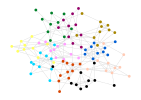

In [3]:
# Parameters
l = 10
k = 10
p_in = 0.4
p_out = 0.01
g = LightGraphs.SimpleGraphs.stochastic_block_model(
    p_in * (k - 1), p_out * k,
    k .* ones(UInt, l), seed = 6
)
communities = [c for c in 1:l for i in 1:k]
labels = Flux.onehotbatch(communities, 1:l)
multin = DiscreteUniform(5, 19)
ufeatures = similar(labels, Float64)
for i in 1:size(ufeatures, 2)
    probs = softmax(convert(Array{Float64}, labels[:, i]))
    ufeatures[:, i] = rand(Multinomial(rand(multin), probs))
end
features = Utils.scale_center(ufeatures)

palette = distinguishable_colors(l)
colors = map(i -> getindex(palette, i), communities)
gplot(g, nodefillc = colors)

In [4]:
palette

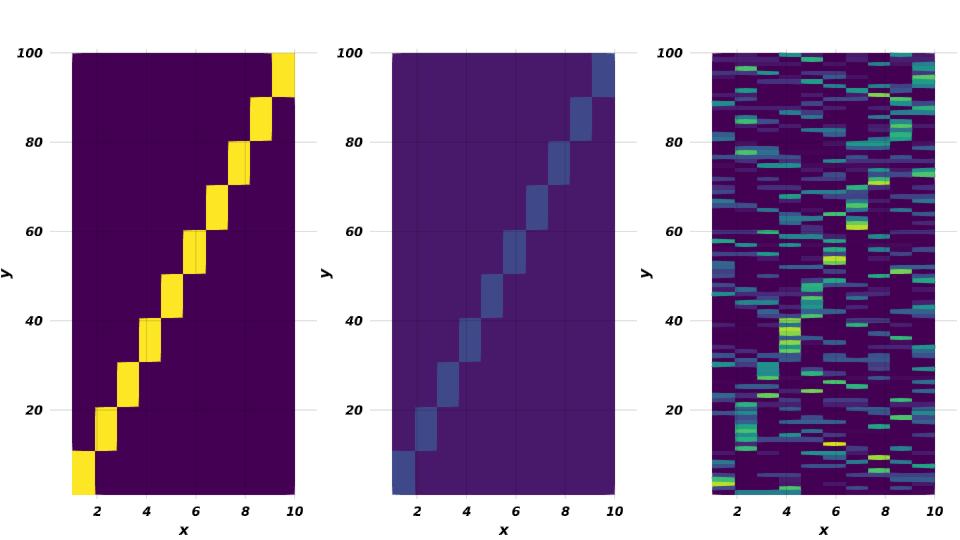

In [5]:
vbox(
    heatmap(1:l, 1:(l*k), labels),
    heatmap(1:l, 1:(l*k), softmax(convert(Array{Float64}, labels)), colorrange = (0, 1)),
    heatmap(1:l, 1:(l*k), features, colorrange = (0, 1))
)

In [6]:
adims(a, dims) = [a[i, :] for i = dims]

function plotstate(;enc, vae, x, refx, g, dims)
    @assert length(dims) in [2, 3]
    embμ, emblogσ = enc(g, x)
    logitÂ, unormF̂ = vae(g, x)
    hbox(
        vbox(
            Scene(),
            heatmap(σ.(logitÂ).data, colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), softmax(unormF̂).data, colorrange = (0, 1)),#, limits = FRect(1, 1, l * k, l * k)),
            sizes = [.45, .45, .1]
        ),
        vbox(
            scatter(adims(embμ, dims)..., color = colors, markersize = Utils.markersize(embμ)),
            heatmap(Array(adjacency_matrix(g)), colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), refx, colorrange = (0, 1)),#, limits = FRect(1, 1, l * k, l * k)),
            sizes = [.45, .45, .1]
        ),
    )
end

plotstate (generic function with 1 method)

In [7]:
module Layers

include("utils.jl")
using Flux, LightGraphs, LinearAlgebra, .Utils

nobias(out::Integer) = fill(nothing, out)
Flux.param(n::AbstractArray{Nothing}) = 0

struct GC{T,U,F}
    W::T
    b::U
    σ::F
end

GC(W, b) = GC(W, b, identity)

function GC(in::Integer, out::Integer, σ = identity;
            initW = Flux.glorot_uniform, initb = zeros)
    return GC(param(initW(out, in)), param(initb(out)), σ)
end

Flux.@treelike GC

function Â(Adiag::AbstractArray)
    Adiag_sumin_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Adiag, dims = 1), dims = 1))
    Adiag_sumout_inv_sqrt = 1 ./ sqrt.(dropdims(sum(Adiag, dims = 2), dims = 2))
    diagm(0 => Adiag_sumout_inv_sqrt) * Adiag * diagm(0 => Adiag_sumin_inv_sqrt)
end
Â(g::SimpleGraph) = Â(Utils.adjacency_matrix_diag(g))

(a::GC)(g::SimpleGraph, x::AbstractArray) = a.σ.((a.W * x * Â(g)) .+ a.b)
(a::GC)(Adiag::AbstractArray, x::AbstractArray) = a.σ.((a.W * x * Â(Adiag)) .+ a.b)

function Base.show(io::IO, l::GC)
    print(io, "GC(g ~ ?, W ~ ", (size(l.W, 2), size(l.W, 1)), ", b ~ ")
    isa(l.b, TrackedArray) ? print(io, size(l.b, 1)) : print(io, "nothing")
    l.σ == identity || print(io, ", ", l.σ)
    print(io, ")")
end


struct Bilin{T,F}
    W::T
    σ::F
end

Bilin() = Bilin(identity)

function Bilin(in::Integer = nothing, σ = identity; initW = Flux.glorot_uniform)
    W = in == nothing ? 1 : param(initW(in, in))
    return Bilin(W, σ)
end

Flux.@treelike Bilin

(a::Bilin)(x::AbstractArray) = a.σ.(transpose(x) * a.W * x)


end

Main.Layers

In [8]:
import Statistics.mean

dimξadj = 2
dimξfeat = 2
diml1 = 10#Int64(round(sqrt(size(features, 1) * (dimξadj + dimξfeat))))
overlap = 1

# FIXME: unshare l1 once we do multitask
l1 = Layers.GC(l, diml1, Flux.relu, initb = Layers.nobias)
lμadj = Layers.GC(diml1, dimξadj, initb = Layers.nobias)
llogσadj = Layers.GC(diml1, dimξadj, initb = Layers.nobias)
lμfeat = Layers.GC(diml1, dimξfeat, initb = Layers.nobias)
llogσfeat = Layers.GC(diml1, dimξfeat, initb = Layers.nobias)

randn_like(target::A) where A<:AbstractArray{T} where T = randn(T, size(target))
mean(a::AbstractArray...) = sum(a) / length(a)

function voverlap(a, b, overlap)
    vcat(
        a[1:end-overlap, :],
        mean(a[end-overlap+1:end, :], b[1:overlap, :]),
        b[1+overlap:end, :]
    )
end

function enc(g, x)
    h = l1(g, x)
    (voverlap(lμadj(g, h), lμfeat(g, h), overlap), voverlap(llogσadj(g, h), llogσfeat(g, h), overlap))
end

sampleξ(μ, logσ) = μ .+ exp.(logσ) .* randn_like(μ)

decadj = Chain(
    Dense(dimξadj, diml1, Flux.relu, initb = Layers.nobias),
    Layers.Bilin(diml1)
)
decl1feat = Layers.GC(dimξfeat, diml1, Flux.relu, initb = Layers.nobias)
decl2feat = Layers.GC(diml1, l, initb = Layers.nobias)

function vae(g, x)
    ξ = sampleξ(enc(g, x)...)
    logitA = decadj(ξ[1:dimξadj, :])
    A = σ.(logitA)
    logitF = decl2feat(A, decl1feat(A, ξ[end-dimξfeat+1:end, :]))
    (logitA, logitF)
end

vae (generic function with 1 method)

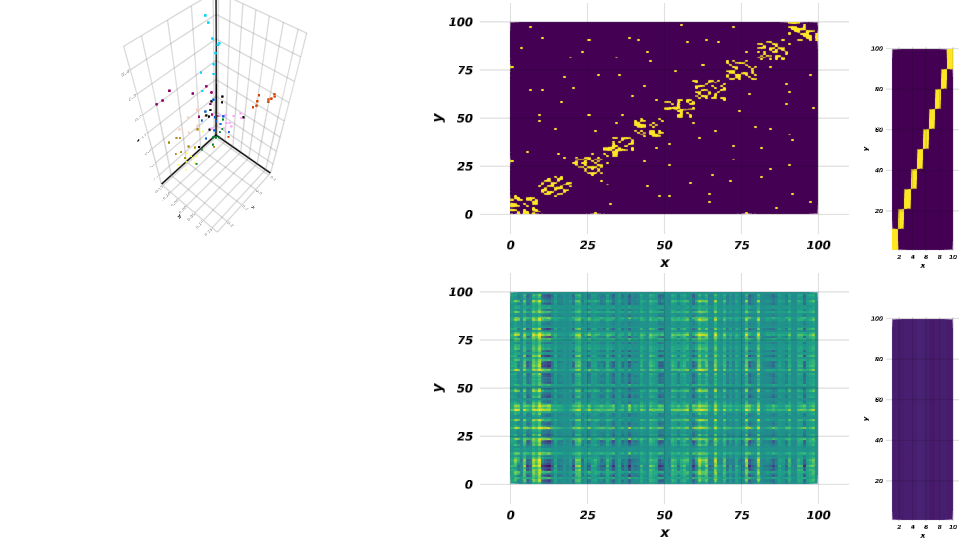

In [9]:
plotstate(enc = enc, vae = vae, x = features, refx = labels, g = g, dims = 1:3)

In [10]:
Adiag = Utils.adjacency_matrix_diag(g)
densityA = mean(adjacency_matrix(g));

In [11]:
# Decoder regularizer
decregularizer(l = 0.01) = l * sum(x -> sum(x.^2), Flux.params(decadj, decl1feat, decl2feat))

# Kullback-Leibler divergence
Lkl(μ, logσ) = 0.5 * sum(exp.(2 .* logσ) + μ.^2 .- 1 .- 2 .* logσ)
κkl = size(g, 1) * (dimξadj - overlap + dimξfeat)

# Adjacency loss
Ladj(logitÂ) = (
    0.5 * sum(Utils.logitbinarycrossentropy.(logitÂ, Adiag, pos_weight = (1 / densityA) - 1))
    / (1 - densityA)
)
κadj = size(g, 1)^2 * log(2)

# Features loss
Lfeat(unormF̂) = - Utils.softmaxcategoricallogprob(unormF̂, labels)
κfeat = size(g, 1) * log(size(features, 1))

# Total loss
klscale = 1e-3
regscale = 1e-3
function loss(μ, logσ, logitÂ, unormF̂)
    (klscale * Lkl(μ, logσ) / κkl
        + Ladj(logitÂ) / κadj
        + Lfeat(unormF̂) / κfeat
        + regscale * decregularizer())
end

function loss(x)
    μ, logσ = enc(g, x)
    ξ = sampleξ(μ, logσ)
    logitÂ = decadj(ξ[1:dimξadj, :])
    Adiag = σ.(logitÂ)
    unormF̂ = decl2feat(Adiag, decl1feat(Adiag, ξ[end-dimξfeat+1:end, :]))
    loss(μ, logσ, logitÂ, unormF̂)
end

loss (generic function with 2 methods)

In [12]:
nepochs = 10000
history_Lkl = zeros(nepochs)
history_Ladj = zeros(nepochs)
history_Lfeat = zeros(nepochs)
history_loss = zeros(nepochs)

opt = ADAM(0.01)
@showprogress for i = 1:nepochs
    Flux.train!(loss, Flux.params(l1, lμadj, llogσadj, lμfeat, llogσfeat, decadj, decl1feat, decl2feat), zip([features]), opt)
    
    μ, logσ = enc(g, features)
    ξ = sampleξ(μ, logσ)
    logitÂ = decadj(ξ[1:dimξadj, :])
    Adiag = σ.(logitÂ)
    unormF̂ = decl2feat(Adiag, decl1feat(Adiag, ξ[end-dimξfeat+1:end, :]))
    
    history_Lkl[i] = Lkl(μ, logσ).data / κkl
    history_Ladj[i] = Ladj(logitÂ).data / κadj
    history_Lfeat[i] = Lfeat(unormF̂).data / κfeat
    history_loss[i] = loss(μ, logσ, logitÂ, unormF̂).data
end

Progress: 100%|█████████████████████████████████████████| Time: 0:09:420:31


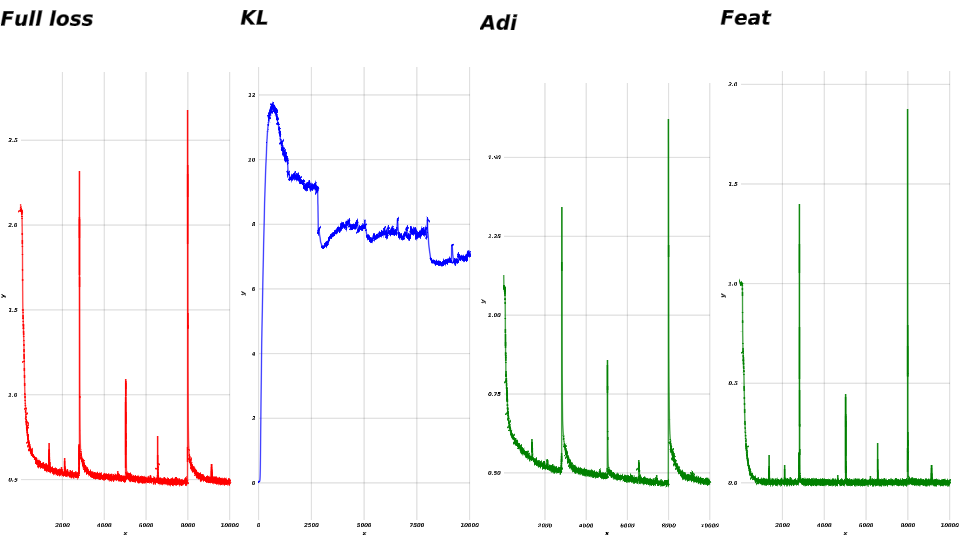

In [13]:
theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
vbox(
    hbox(lines(1:nepochs, history_loss, color = :red), text(theme, "Full loss")),
    hbox(lines(1:nepochs, history_Lkl, color = :blue), text(theme, "KL")),
    hbox(lines(1:nepochs, history_Ladj, color = :green), text(theme, "Adj")),
    hbox(lines(1:nepochs, history_Lfeat, color = :green), text(theme, "Feat"))
)

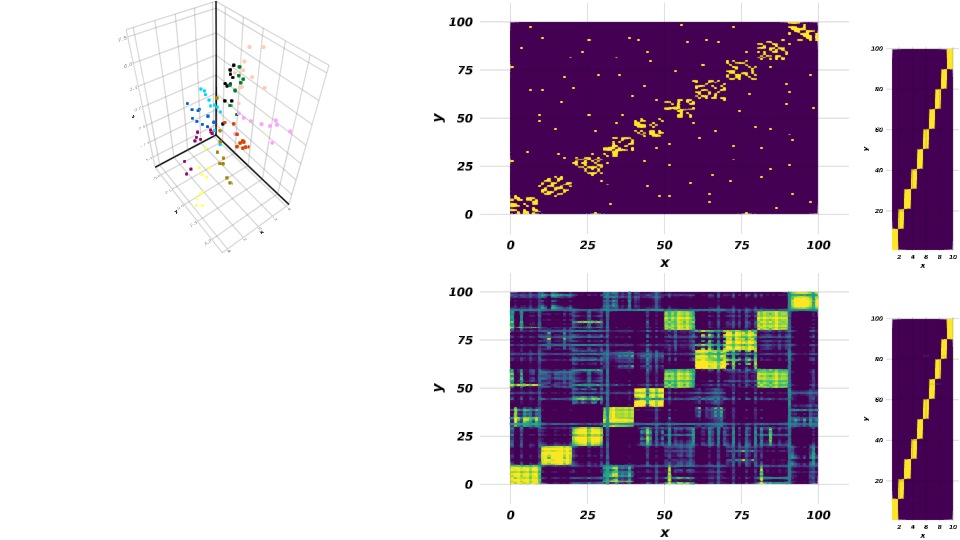

In [14]:
plotstate(enc = enc, vae = vae, x = features, refx = labels, g = g, dims = 1:3)